1. Data processing :
two files to be processes : temperature file and population file

In [1]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
import pandas as pd
from importlib import reload
import functions as f
from tqdm import tqdm
import plotly.express as px
reload(f)

<module 'functions' from 'c:\\Users\\croge\\OneDrive\\Documents\\cours EPFL\\MA3\\ML_project\\UHI_prediction\\functions.py'>

In [2]:
'''lyon_sample = xr.open_dataset(r'lyon_data\tas_Lyon_UrbClim_2011_07_v1.0.nc')
#reverse y axis
lyon_sample = lyon_sample.reindex(y=list(reversed(lyon_sample.y)))
#create an animated plot of the temperature in Lyon for the 24 first hours of the month of July 2011
fig = px.imshow(lyon_sample.tas[0:24,:,:], animation_frame='time', color_continuous_scale='Spectral_r', width=750, height=550)
fig.update_layout(title='Temperature in Lyon for the 24 first hours of the month of July 2011')
fig.show()'''

"lyon_sample = xr.open_dataset(r'lyon_data\tas_Lyon_UrbClim_2011_07_v1.0.nc')\n#reverse y axis\nlyon_sample = lyon_sample.reindex(y=list(reversed(lyon_sample.y)))\n#create an animated plot of the temperature in Lyon for the 24 first hours of the month of July 2011\nfig = px.imshow(lyon_sample.tas[0:24,:,:], animation_frame='time', color_continuous_scale='Spectral_r', width=750, height=550)\nfig.update_layout(title='Temperature in Lyon for the 24 first hours of the month of July 2011')\nfig.show()"

In [11]:
reload(f)
data = pd.DataFrame({'temp':[], 'month':[], 'pop':[], 'deltaT':[]})
rur_urb_mask = xr.open_dataset(r'lyon_data\ruralurbanmask_Lyon_UrbClim_v1.0.nc')
for i in tqdm(range(1,13)):
    month = str(i).zfill(2)
    path_file_temp = os.path.join('lyon_data', 'tas_Lyon_UrbClim_2011_'+month+'_v1.0.nc')
    path_file_pop = os.path.join('data_population_day', 'ENACT_POP_D'+month+'2011_EU28_R2020A_4326_30ss_V1_0.tif')
    path_fil_hum = os.path.join('lyon_data', 'russ_Lyon_UrbClim_2011_'+month+'_v1.0.nc')
    path_file_ws = os.path.join('lyon_data', 'sfcWind_Lyon_UrbClim_2011_'+month+'_v1.0.nc')
    temp = xr.open_dataset(path_file_temp)
    hum = xr.open_dataset(path_fil_hum)
    ws = xr.open_dataset(path_file_ws)
    pop = rio.open(path_file_pop)

    cropped_pop, _ = f.crop_and_downgrade(pop, temp_city = temp)
    cropped_pop_resampled = f.resample_image(cropped_pop, [temp.dims['x'], temp.dims['y']])

    #create indexes to sample the data
    N = temp.dims['x']*temp.dims['y']*temp.time.shape[0]
    idx = np.random.choice(N, 10000, replace=False)


    delta_T = f.compute_deltaT_urban(temp, rur_urb_mask)[idx]
    temperatures = temp.tas[:,:,:].values.flatten()[idx]
    humidity = hum.russ[:,:,:].values.flatten()[idx]
    wind_speed = ws.sfcWind[:,:,:].values.flatten()[idx]
    population = np.tile(cropped_pop_resampled.flatten(), temp.time.shape[0])[idx]

    if i == 1:
        data = pd.DataFrame({'temp': temperatures, 'month': i, 'pop': population, 'deltaT': delta_T, 'hum': humidity, 'ws': wind_speed})
    else:
        data = pd.concat([data, pd.DataFrame({'temp': temperatures, 'month': i, 'pop': population, 'deltaT': delta_T, 'hum': humidity, 'ws': wind_speed})])

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [05:25<00:00, 27.09s/it]


In [21]:
data.to_csv('data_lyon.csv')
data.head()

,temp,month,pop,deltaT,hum,ws
0,274.976959,1,1523.592613,2.887177,58.565681,1.229084
1,278.476654,1,1416.265328,0.170105,87.768723,2.406370
2,271.715515,1,834.930823,0.821411,73.874382,3.112893
3,272.907410,1,48.710647,0.649628,78.595543,5.524080
4,279.508057,1,470.104484,1.585938,76.023857,2.344400


In [3]:
pd.read_csv('data_lyon.csv').head().drop('Unnamed: 0', axis=1)

,temp,month,pop,deltaT,hum,ws
0,274.97696,1,1523.592613,2.887176,58.56568,1.229084
1,278.47665,1,1416.265328,0.170105,87.76872,2.406370
2,271.71550,1,834.930823,0.821411,73.87438,3.112893
3,272.90740,1,48.710647,0.649628,78.59554,5.524080
4,279.50806,1,470.104484,1.585938,76.02386,2.344400


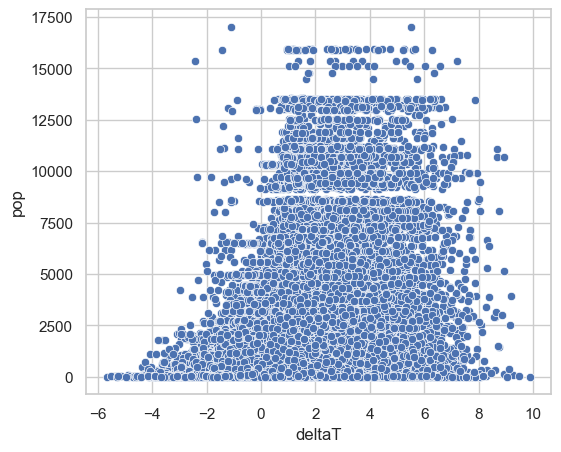

In [19]:

import seaborn as sns
plt.figure(figsize=(6,5))
sns.set_theme(style="whitegrid")
sns.scatterplot(data=data, x="deltaT", y="pop")
plt.show()


In [31]:
#create a decision tree regressor to predict the temperature based on the population
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

X = data[['pop', 'ws', 'hum']]
y = data['deltaT']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
tree_reg = DecisionTreeRegressor(max_depth=5)
tree_reg.fit(X_train, y_train)
y_pred = tree_reg.predict(X_test)
print('MSE: ', mean_squared_error(y_test, y_pred))
print('R2: ', r2_score(y_test, y_pred))

'''#plot the decision tree
from sklearn.tree import plot_tree
plt.figure(figsize=(20,10))
plot_tree(tree_reg, filled=True, feature_names=['pop'], rounded=True, fontsize=14)
plt.show()'''

MSE:  30.2259916320357
R2:  0.4448378863314755


"#plot the decision tree\nfrom sklearn.tree import plot_tree\nplt.figure(figsize=(20,10))\nplot_tree(tree_reg, filled=True, feature_names=['pop'], rounded=True, fontsize=14)\nplt.show()"

In [33]:
#create a random forest regressor to predict the temperature based on the population
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(n_estimators=50, max_depth=5, verbose=2)
forest_reg.fit(X_train, y_train)
y_pred = forest_reg.predict(X_test)
print('MSE: ', mean_squared_error(y_test, y_pred))
print('R2: ', r2_score(y_test, y_pred))


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   27.0s


building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
MSE:  29.96316229619713
R2:  0.44966528426748187


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


In [34]:
#build an extra tree regressor to predict the temperature based on the population
from sklearn.ensemble import ExtraTreesRegressor
extra_tree_reg = ExtraTreesRegressor(n_estimators=100, max_depth=5, verbose=2)
extra_tree_reg.fit(X_train, y_train)
y_pred = extra_tree_reg.predict(X_test)
print('MSE: ', mean_squared_error(y_test, y_pred))
print('R2: ', r2_score(y_test, y_pred))


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.2s


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


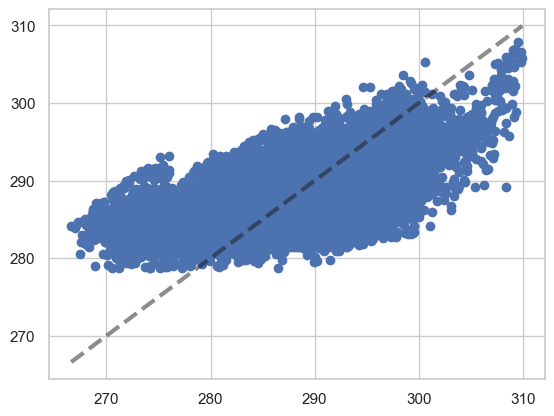

In [39]:
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3, alpha = 0.5)
plt.scatter(y_test, y_pred)